# 🧹 Preprocessing and Baseline Models
## Halal-Haram Food Detection Project

**Tujuan Notebook**: Membersihkan data, membuat dataset split yang definitif, dan membuat model baseline (non-Deep Learning) sebagai pembanding untuk model deep learning.

**Output yang Diharapkan**:
- Dataset split (train/validation/test) yang konsisten
- Text preprocessing pipeline yang optimal
- Model baseline dengan TF-IDF + Machine Learning klasik
- Benchmark performa untuk model deep learning

---

## 1. 📚 Import Libraries
Mengimpor semua library yang diperlukan untuk preprocessing dan modeling.

In [1]:
# Data manipulation dan analisis
import pandas as pd
import numpy as np
import json
import re
import string
from collections import Counter

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Scikit-learn untuk preprocessing dan modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Model persistence
import joblib
import pickle

# Download NLTK data jika belum ada
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Konfigurasi visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Semua library berhasil diimpor!")
print(f"🎲 Random state: {RANDOM_STATE}")

✅ Semua library berhasil diimpor!
🎲 Random state: 42


[nltk_data] Downloading package punkt to C:\Users\Muhammad Irfan
[nltk_data]     Karim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Muhammad Irfan
[nltk_data]     Karim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Muhammad Irfan
[nltk_data]     Karim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. 📂 Load Data dan Analysis Summary
Memuat dataset dan hasil analisis dari notebook sebelumnya.

In [2]:
# Load dataset
try:
    df = pd.read_csv('dataset/bilingual_dataset.csv', encoding='utf-8')
    print(f"✅ Dataset berhasil dimuat: {df.shape[0]} baris, {df.shape[1]} kolom")
except FileNotFoundError:
    print("❌ File 'dataset/bilingual_dataset.csv' tidak ditemukan!")
    raise

# Load analysis summary dari notebook sebelumnya
try:
    with open('data_analysis_summary.json', 'r', encoding='utf-8') as f:
        analysis_summary = json.load(f)
    print("✅ Analysis summary berhasil dimuat dari notebook sebelumnya")
    
    # Extract informasi penting
    label_col = analysis_summary['label_info']['label_column']
    text_col = analysis_summary['text_stats']['text_column']
    recommended_max_length = analysis_summary['text_stats']['recommended_max_length']
    is_balanced = analysis_summary['label_info']['is_balanced']
    
    print(f"📊 Label column: '{label_col}'")
    print(f"📝 Text column: '{text_col}'")
    print(f"📏 Recommended max length: {recommended_max_length} words")
    print(f"⚖️ Dataset balanced: {is_balanced}")
    
except FileNotFoundError:
    print("⚠️ Analysis summary tidak ditemukan, menggunakan default values")
    # Default values jika file tidak ada
    label_col = df.columns[-1]  # Asumsi kolom terakhir adalah label
    text_col = df.columns[0]    # Asumsi kolom pertama adalah text
    recommended_max_length = 100
    is_balanced = True
    
    print(f"📊 Using default - Label column: '{label_col}'")
    print(f"📝 Using default - Text column: '{text_col}'")

# Tampilkan preview data
print("\n🔍 Preview data:")
display(df.head())

print(f"\n📈 Distribusi label:")
display(df[label_col].value_counts())
print(f"\nPersentase:")
display(df[label_col].value_counts(normalize=True) * 100)

✅ Dataset berhasil dimuat: 123449 baris, 2 kolom
✅ Analysis summary berhasil dimuat dari notebook sebelumnya
📊 Label column: 'label'
📝 Text column: 'text'
📏 Recommended max length: 122 words
⚖️ Dataset balanced: True

🔍 Preview data:


,text,label
0,pure organic maple air filtered pasteurized,halal
1,air franks dibuat dengan ayam babi and daging ...,haram
2,enriched flour wheat flour malted barley flour...,haram
3,carbonated air air carbon dioxide gula asam si...,halal
4,wild blueberries blackberries raspberries,halal



📈 Distribusi label:


label
halal    67706
haram    55743
Name: count, dtype: int64


Persentase:


label
halal    54.845321
haram    45.154679
Name: proportion, dtype: float64

## 3. 🧹 Text Preprocessing
Membuat pipeline preprocessing teks yang komprehensif dan optimal.

🧹 BILINGUAL TEXT PREPROCESSING PIPELINE
   English + Indonesian Support

📦 Initializing preprocessing tools...
✅ English stopwords: 224
✅ Indonesian stopwords: 141
✅ Preserved keywords: 31

📂 Loading bilingual dataset...
✅ Loaded 123,449 samples
   Columns: ['text', 'label']

🌍 Detecting language distribution...
   Sample distribution (first 1000):
   - en: 510 (51.0%)
   - mixed: 407 (40.7%)
   - id: 83 (8.3%)

🔄 Applying preprocessing pipeline...
   This may take a few minutes for 123K samples...
✅ Preprocessing completed!

📊 PREPROCESSING STATISTICS

📈 Text Length Statistics:
   Original:
   - Mean characters: 299.3
   - Mean words: 43.2
   - Median words: 31.0

   After Cleaning:
   - Mean characters: 261.2
   - Mean words: 37.1
   - Median words: 26.0

   Reduction:
   - Characters: 12.7%
   - Words: 14.2%

🏷️  Label Distribution:
   - halal: 67,706 (54.8%)
   - haram: 55,743 (45.2%)

⚠️  Warning: 9 texts became empty after cleaning
   This is 0.01% of total

📝 PREPROCESSING EXAMP

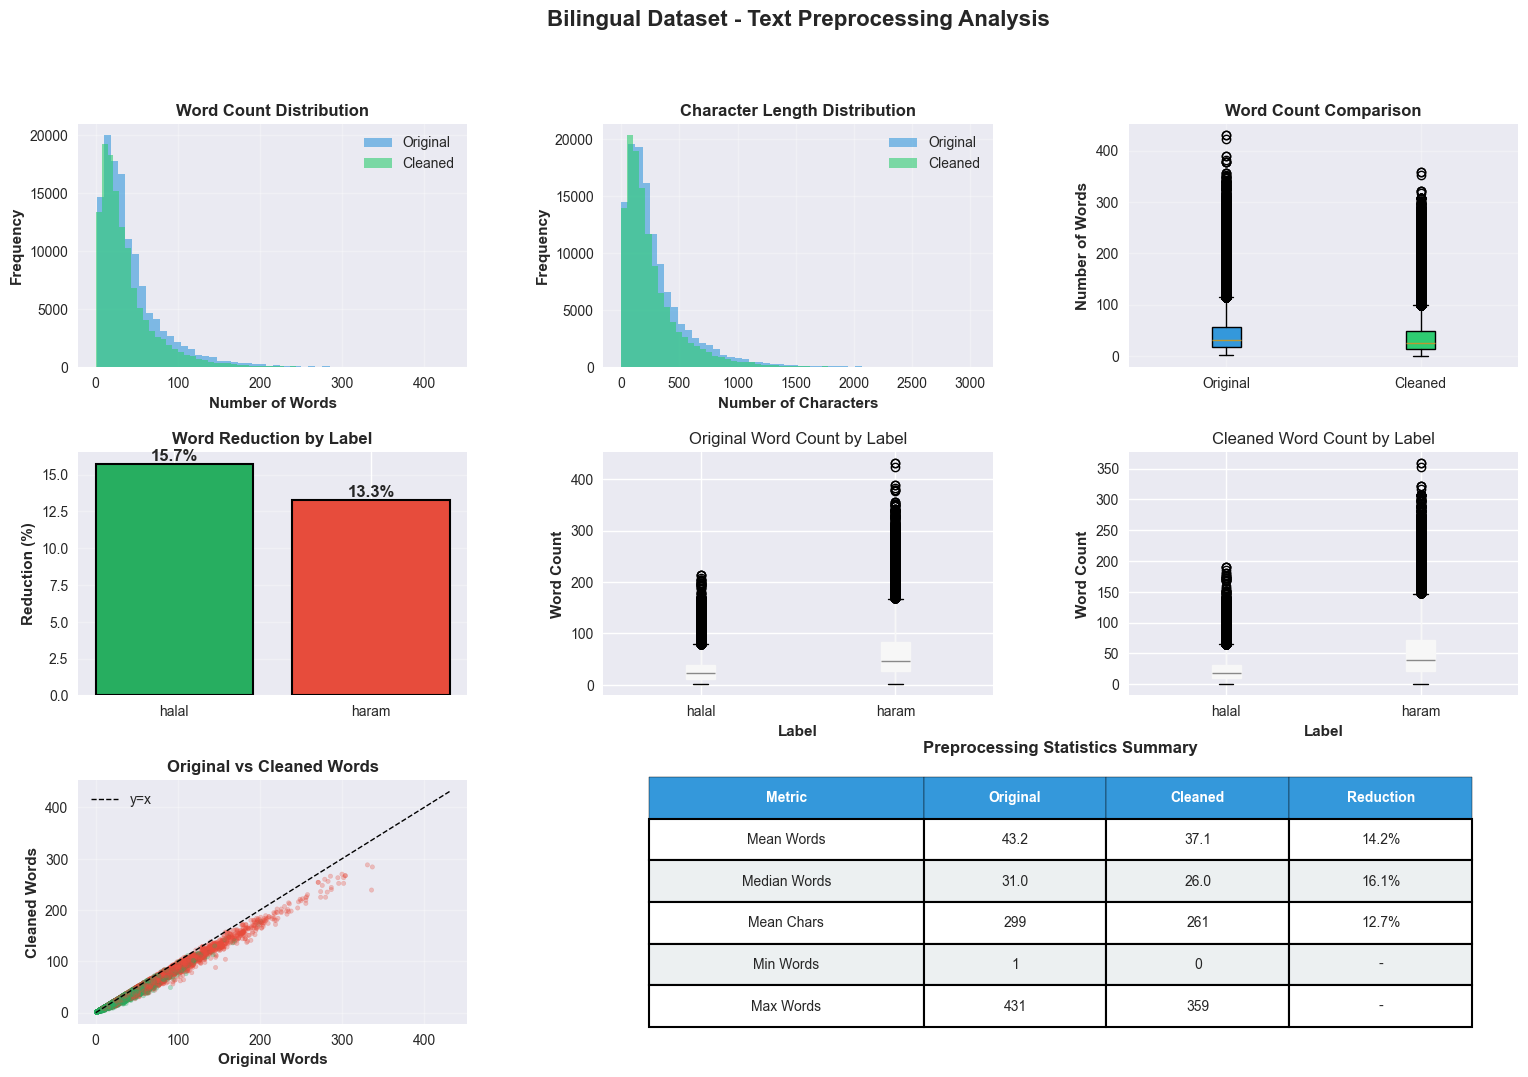

In [4]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Download NLTK data (jika belum ada)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')

print("="*80)
print("🧹 BILINGUAL TEXT PREPROCESSING PIPELINE")
print("   English + Indonesian Support")
print("="*80)

# ============================================================================
# INITIALIZATION
# ============================================================================

print("\n📦 Initializing preprocessing tools...")

# English tools
stemmer_en = PorterStemmer()
lemmatizer_en = WordNetLemmatizer()
stop_words_en = set(stopwords.words('english'))

# Indonesian tools
factory_stemmer = StemmerFactory()
stemmer_id = factory_stemmer.create_stemmer()
factory_stopwords = StopWordRemoverFactory()
stop_words_id = set(factory_stopwords.get_stop_words())

# Custom stopwords for food ingredients (bilingual)
custom_stopwords_en = {
    'and', 'or', 'with', 'contains', 'may', 'contain', 'less', 'than', 
    'added', 'natural', 'artificial', 'flavor', 'flavoring', 'color', 
    'coloring', 'preservative', 'stabilizer', 'emulsifier', 'enriched',
    'certified', 'organic', 'made', 'from', 'including', 'following',
    'one', 'two', 'more', 'also', 'percent', 'minimum', 'maximum'
}

custom_stopwords_id = {
    'dan', 'atau', 'dengan', 'mengandung', 'dari', 'untuk', 'yang',
    'dibuat', 'terdiri', 'berisi', 'ditambah', 'ditambahkan', 'alami',
    'buatan', 'perisa', 'pewarna', 'pengawet', 'diperkaya', 'organik',
    'satu', 'dua', 'lebih', 'juga', 'persen', 'minimum', 'maksimum'
}

stop_words_en.update(custom_stopwords_en)
stop_words_id.update(custom_stopwords_id)

# Combined stopwords
stop_words_combined = stop_words_en.union(stop_words_id)

# Important keywords to preserve (never remove)
preserve_keywords = {
    # Haram ingredients - English
    'pork', 'bacon', 'ham', 'lard', 'wine', 'beer', 'alcohol', 'rum',
    'whiskey', 'vodka', 'gelatin', 'clam', 'oyster', 'mussel',
    # Haram ingredients - Indonesian
    'babi', 'anggur', 'bir', 'alkohol', 'wiski', 'kerang', 'tiram', 'remis',
    # Halal indicators
    'chicken', 'ayam', 'beef', 'sapi', 'vegetable', 'sayur', 'nabati',
    'halal', 'haram'
}

print(f"✅ English stopwords: {len(stop_words_en)}")
print(f"✅ Indonesian stopwords: {len(stop_words_id)}")
print(f"✅ Preserved keywords: {len(preserve_keywords)}")

# ============================================================================
# PREPROCESSING FUNCTIONS
# ============================================================================

def detect_language(text):
    """
    Detect if text is primarily English, Indonesian, or Mixed
    """
    words = text.lower().split()
    
    # Count English vs Indonesian words (simple heuristic)
    en_indicators = sum(1 for w in words if w in stop_words_en and w not in stop_words_id)
    id_indicators = sum(1 for w in words if w in stop_words_id and w not in stop_words_en)
    
    if en_indicators > id_indicators * 2:
        return 'en'
    elif id_indicators > en_indicators * 2:
        return 'id'
    else:
        return 'mixed'

def normalize_text(text):
    """
    Basic text normalization
    """
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    
    # Normalize common variations
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single
    text = re.sub(r'(\d+)\s*%', r'\1percent', text)  # 5% → 5percent
    text = re.sub(r'andor', 'or', text)  # and/or → or
    
    # Remove special characters but keep important ones
    text = re.sub(r'[^\w\s\-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def clean_bilingual_text(text, 
                         remove_stopwords=True,
                         preserve_important=True,
                         apply_stemming=False,
                         min_word_length=2,
                         max_word_length=50):
    """
    Comprehensive bilingual text cleaning for English + Indonesian
    
    Parameters:
    -----------
    text : str
        Input text to clean
    remove_stopwords : bool
        Remove stopwords (preserving important keywords)
    preserve_important : bool
        Always keep important keywords (haram/halal indicators)
    apply_stemming : bool
        Apply language-specific stemming
    min_word_length : int
        Minimum word length to keep
    max_word_length : int
        Maximum word length (filter out errors)
    
    Returns:
    --------
    str : Cleaned text
    """
    if pd.isna(text):
        return ""
    
    # Normalize text
    text = normalize_text(text)
    
    # Tokenize
    tokens = text.split()
    
    # Detect language
    lang = detect_language(text)
    
    # Filter and process tokens
    filtered_tokens = []
    for token in tokens:
        # Skip if too short or too long
        if len(token) < min_word_length or len(token) > max_word_length:
            continue
        
        # Always preserve important keywords
        if preserve_important and token in preserve_keywords:
            filtered_tokens.append(token)
            continue
        
        # Remove stopwords
        if remove_stopwords and token in stop_words_combined:
            continue
        
        # Apply language-specific stemming if requested
        if apply_stemming:
            if lang == 'en':
                token = stemmer_en.stem(token)
            elif lang == 'id':
                token = stemmer_id.stem(token)
            # For mixed, use English stemmer as default
            else:
                token = stemmer_en.stem(token)
        
        filtered_tokens.append(token)
    
    return ' '.join(filtered_tokens)

def advanced_clean(text):
    """
    Advanced cleaning with more aggressive preprocessing
    """
    text = clean_bilingual_text(text, 
                                remove_stopwords=True,
                                preserve_important=True,
                                apply_stemming=False)
    
    # Remove very rare characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove single characters except important ones
    tokens = text.split()
    tokens = [t for t in tokens if len(t) > 1 or t in {'a', 'b', 'c', 'd'}]
    
    return ' '.join(tokens)

# ============================================================================
# LOAD AND PREPROCESS DATASET
# ============================================================================

print("\n📂 Loading bilingual dataset...")
df = pd.read_csv('dataset/bilingual_dataset.csv')

print(f"✅ Loaded {len(df):,} samples")
print(f"   Columns: {df.columns.tolist()}")

# Detect language distribution
print("\n🌍 Detecting language distribution...")
if 'source' in df.columns:
    source_counts = df['source'].value_counts()
    print("   Distribution by source:")
    for source, count in source_counts.items():
        print(f"   - {source}: {count:,} ({count/len(df)*100:.1f}%)")
else:
    # Sample detection
    sample_langs = df['text'].head(1000).apply(detect_language).value_counts()
    print("   Sample distribution (first 1000):")
    for lang, count in sample_langs.items():
        print(f"   - {lang}: {count:,} ({count/1000*100:.1f}%)")

# ============================================================================
# APPLY PREPROCESSING
# ============================================================================

print("\n🔄 Applying preprocessing pipeline...")
print("   This may take a few minutes for 123K samples...")

# Original text statistics
df['original_length'] = df['text'].apply(lambda x: len(str(x)))
df['original_words'] = df['text'].apply(lambda x: len(str(x).split()))

# Apply cleaning
df['cleaned_text'] = df['text'].apply(clean_bilingual_text)
df['cleaned_advanced'] = df['text'].apply(advanced_clean)

# Cleaned text statistics
df['cleaned_length'] = df['cleaned_text'].apply(lambda x: len(str(x)))
df['cleaned_words'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))

print("✅ Preprocessing completed!")

# ============================================================================
# STATISTICS & ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("📊 PREPROCESSING STATISTICS")
print("="*80)

print("\n📈 Text Length Statistics:")
print(f"   Original:")
print(f"   - Mean characters: {df['original_length'].mean():.1f}")
print(f"   - Mean words: {df['original_words'].mean():.1f}")
print(f"   - Median words: {df['original_words'].median():.1f}")

print(f"\n   After Cleaning:")
print(f"   - Mean characters: {df['cleaned_length'].mean():.1f}")
print(f"   - Mean words: {df['cleaned_words'].mean():.1f}")
print(f"   - Median words: {df['cleaned_words'].median():.1f}")

reduction_chars = (1 - df['cleaned_length'].mean() / df['original_length'].mean()) * 100
reduction_words = (1 - df['cleaned_words'].mean() / df['original_words'].mean()) * 100

print(f"\n   Reduction:")
print(f"   - Characters: {reduction_chars:.1f}%")
print(f"   - Words: {reduction_words:.1f}%")

# Check label distribution after cleaning
print("\n🏷️  Label Distribution:")
label_counts = df['label'].value_counts()
for label, count in label_counts.items():
    print(f"   - {label}: {count:,} ({count/len(df)*100:.1f}%)")

# Check for empty texts after cleaning
empty_cleaned = sum(df['cleaned_text'].str.len() == 0)
if empty_cleaned > 0:
    print(f"\n⚠️  Warning: {empty_cleaned} texts became empty after cleaning")
    print(f"   This is {empty_cleaned/len(df)*100:.2f}% of total")

# ============================================================================
# EXAMPLES
# ============================================================================

print("\n" + "="*80)
print("📝 PREPROCESSING EXAMPLES")
print("="*80)

# Show examples from different categories
sample_indices = [0, 100, 1000, 10000, 50000]

for i in sample_indices[:5]:
    if i < len(df):
        print(f"\n{'-'*80}")
        print(f"Sample #{i+1} - Label: {df.iloc[i]['label'].upper()}")
        print(f"\nOriginal ({df.iloc[i]['original_words']} words):")
        print(f"  {df.iloc[i]['text'][:150]}...")
        print(f"\nCleaned ({df.iloc[i]['cleaned_words']} words):")
        print(f"  {df.iloc[i]['cleaned_text'][:150]}...")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n📊 Generating visualizations...")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# 1. Word count distribution comparison
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(df['original_words'], bins=50, alpha=0.6, label='Original', color='#3498db')
ax1.hist(df['cleaned_words'], bins=50, alpha=0.6, label='Cleaned', color='#2ecc71')
ax1.set_xlabel('Number of Words', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Word Count Distribution', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Character length distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(df['original_length'], bins=50, alpha=0.6, label='Original', color='#3498db')
ax2.hist(df['cleaned_length'], bins=50, alpha=0.6, label='Cleaned', color='#2ecc71')
ax2.set_xlabel('Number of Characters', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Character Length Distribution', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Box plot comparison
ax3 = fig.add_subplot(gs[0, 2])
box_data = [df['original_words'], df['cleaned_words']]
bp = ax3.boxplot(box_data, labels=['Original', 'Cleaned'], patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#2ecc71')
ax3.set_ylabel('Number of Words', fontweight='bold')
ax3.set_title('Word Count Comparison', fontweight='bold', fontsize=12)
ax3.grid(alpha=0.3)

# 4. Reduction rate by label
ax4 = fig.add_subplot(gs[1, 0])
reduction_by_label = df.groupby('label').apply(
    lambda x: (1 - x['cleaned_words'].mean() / x['original_words'].mean()) * 100
)
colors = ['#27ae60' if label == 'halal' else '#e74c3c' for label in reduction_by_label.index]
bars = ax4.bar(reduction_by_label.index, reduction_by_label.values, color=colors, 
              edgecolor='black', linewidth=1.5)
ax4.set_ylabel('Reduction (%)', fontweight='bold')
ax4.set_title('Word Reduction by Label', fontweight='bold', fontsize=12)
ax4.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# 5. Word count by label (before)
ax5 = fig.add_subplot(gs[1, 1])
df.boxplot(column='original_words', by='label', ax=ax5, patch_artist=True)
ax5.set_xlabel('Label', fontweight='bold')
ax5.set_ylabel('Word Count', fontweight='bold')
ax5.set_title('Original Word Count by Label', fontweight='bold', fontsize=12)
ax5.get_figure().suptitle('')
plt.setp(ax5, title='Original Word Count by Label')

# 6. Word count by label (after)
ax6 = fig.add_subplot(gs[1, 2])
df.boxplot(column='cleaned_words', by='label', ax=ax6, patch_artist=True)
ax6.set_xlabel('Label', fontweight='bold')
ax6.set_ylabel('Word Count', fontweight='bold')
ax6.set_title('Cleaned Word Count by Label', fontweight='bold', fontsize=12)
ax6.get_figure().suptitle('')
plt.setp(ax6, title='Cleaned Word Count by Label')

# 7. Scatter: Original vs Cleaned words
ax7 = fig.add_subplot(gs[2, 0])
sample_size = min(10000, len(df))
sample_df = df.sample(sample_size, random_state=42)
colors_scatter = ['#27ae60' if label == 'halal' else '#e74c3c' 
                 for label in sample_df['label']]
ax7.scatter(sample_df['original_words'], sample_df['cleaned_words'], 
           alpha=0.3, c=colors_scatter, s=10)
ax7.plot([0, df['original_words'].max()], [0, df['original_words'].max()], 
        'k--', linewidth=1, label='y=x')
ax7.set_xlabel('Original Words', fontweight='bold')
ax7.set_ylabel('Cleaned Words', fontweight='bold')
ax7.set_title('Original vs Cleaned Words', fontweight='bold', fontsize=12)
ax7.legend()
ax7.grid(alpha=0.3)

# 8. Statistics summary table
ax8 = fig.add_subplot(gs[2, 1:])
ax8.axis('off')

summary_data = [
    ['Metric', 'Original', 'Cleaned', 'Reduction'],
    ['Mean Words', f"{df['original_words'].mean():.1f}", 
     f"{df['cleaned_words'].mean():.1f}", f"{reduction_words:.1f}%"],
    ['Median Words', f"{df['original_words'].median():.1f}", 
     f"{df['cleaned_words'].median():.1f}", 
     f"{(1 - df['cleaned_words'].median()/df['original_words'].median())*100:.1f}%"],
    ['Mean Chars', f"{df['original_length'].mean():.0f}", 
     f"{df['cleaned_length'].mean():.0f}", f"{reduction_chars:.1f}%"],
    ['Min Words', f"{df['original_words'].min():.0f}", 
     f"{df['cleaned_words'].min():.0f}", '-'],
    ['Max Words', f"{df['original_words'].max():.0f}", 
     f"{df['cleaned_words'].max():.0f}", '-'],
]

table = ax8.table(cellText=summary_data, cellLoc='center', loc='center',
                 colWidths=[0.3, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style alternating rows
for i in range(1, len(summary_data)):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ecf0f1')
        table[(i, j)].set_edgecolor('black')
        table[(i, j)].set_linewidth(1.5)

ax8.set_title('Preprocessing Statistics Summary', fontweight='bold', 
             fontsize=12, pad=20)

# Main title
fig.suptitle('Bilingual Dataset - Text Preprocessing Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('plot/preprocessing_analysis.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Visualization saved: preprocessing_analysis.png")

# ============================================================================
# SAVE PREPROCESSED DATA
# ============================================================================

print("\n💾 Saving preprocessed data...")

# Save with cleaned text
df_output = df[['text', 'cleaned_text', 'label']]
df_output.to_csv('dataset/bilingual_dataset_cleaned.csv', 
                 index=False)
print(f"✅ Saved: bilingual_dataset_cleaned.csv ({len(df_output):,} rows)")

# Save with advanced cleaning
df_advanced = df[['text', 'cleaned_advanced', 'label']].rename(
    columns={'cleaned_advanced': 'cleaned_text'}
)
df_advanced.to_csv('dataset/bilingual_dataset_cleaned_advanced.csv', 
                   index=False)
print(f"✅ Saved: bilingual_dataset_cleaned_advanced.csv ({len(df_advanced):,} rows)")

# Save statistics
stats_dict = {
    'total_samples': len(df),
    'halal_samples': sum(df['label'] == 'halal'),
    'haram_samples': sum(df['label'] == 'haram'),
    'original_mean_words': df['original_words'].mean(),
    'cleaned_mean_words': df['cleaned_words'].mean(),
    'word_reduction_percent': reduction_words,
    'char_reduction_percent': reduction_chars,
    'empty_after_cleaning': empty_cleaned,
    'min_words_after_cleaning': df['cleaned_words'].min(),
    'max_words_after_cleaning': df['cleaned_words'].max(),
}

with open('dataset/preprocessing_statistics.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("BILINGUAL DATASET PREPROCESSING STATISTICS\n")
    f.write("="*80 + "\n\n")
    for key, value in stats_dict.items():
        if isinstance(value, float):
            f.write(f"{key}: {value:.2f}\n")
        else:
            f.write(f"{key}: {value:,}\n")

print("✅ Saved: preprocessing_statistics.txt")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("✅ PREPROCESSING COMPLETE!")
print("="*80)

print(f"""
📊 Summary:
   - Processed: {len(df):,} samples
   - Word reduction: {reduction_words:.1f}%
   - Output files:
     • bilingual_dataset_cleaned.csv
     • bilingual_dataset_cleaned_advanced.csv
     • preprocessing_analysis.png
     • preprocessing_statistics.txt

🎯 Recommendations:
   1. Use 'cleaned_text' for standard training
   2. Use 'cleaned_advanced' for more aggressive preprocessing
   3. Verify that important keywords (pork, babi, etc.) are preserved
   4. Check visualization for any anomalies

⚠️  Important Notes:
   - Stopwords removed but important keywords preserved
   - Bilingual support (English + Indonesian)
   - No stemming applied by default (preserves meaning)
   - Label distribution maintained

🚀 Ready for model training!
""")

plt.show()

## 4. 📊 Train-Validation-Test Split
Membuat pembagian dataset yang stratified dan konsisten untuk semua eksperimen.

📊 TRAIN-VALIDATION-TEST SPLIT FOR BILINGUAL DATASET

📂 Configuration:
   Input file: dataset/bilingual_dataset_cleaned.csv
   Output directory: data_splits/
   Random state: 42
   Test size: 20.0%
   Validation size: 10.0%

📥 Loading cleaned dataset...
✅ Loaded 123,449 samples
   Columns: ['text', 'cleaned_text', 'label']

📝 Using columns:
   Text column: 'cleaned_text'
   Label column: 'label'

🔍 Analyzing data...

⚠️  Warning: Found missing values
   Missing text: 9
   Missing labels: 0
   Removed 9 rows with missing values
   Remaining: 123,440 samples

🏷️  Label information:
   Label mapping: {'halal': 0, 'haram': 1}

📊 Original label distribution:
   halal: 67,704 (54.8%)
   haram: 55,736 (45.2%)

🔄 Performing stratified split...
   Strategy: Train (70%) - Val (10%) - Test (20%)
   ✅ First split: 98,752 train+val, 24,688 test
   ✅ Second split: 86,408 train, 12,344 val

📈 Final dataset split sizes:
   Total dataset: 123,440 samples
   Training set:   86,408 samples (70.0%)
   Vali

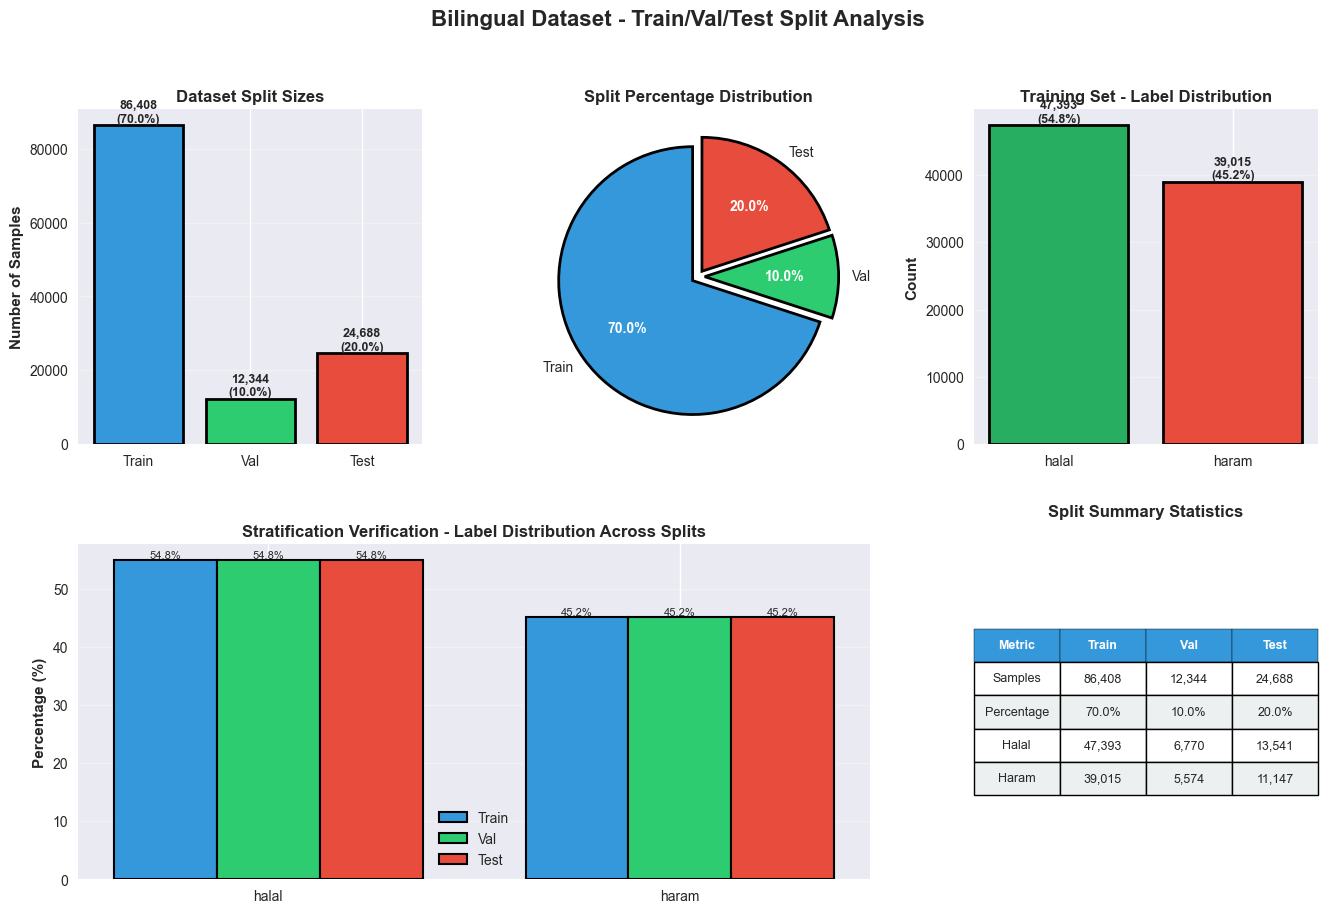


✅ All done! Happy training! 🎓


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("📊 TRAIN-VALIDATION-TEST SPLIT FOR BILINGUAL DATASET")
print("="*80)

# Configuration
RANDOM_STATE = 42
TEST_SIZE = 0.2      # 20% for test
VAL_SIZE = 0.125     # 12.5% of remaining (10% of total)

# Input files
INPUT_FILE = 'dataset/bilingual_dataset_cleaned.csv'
OUTPUT_DIR = 'data_splits/'

print(f"\n📂 Configuration:")
print(f"   Input file: {INPUT_FILE}")
print(f"   Output directory: {OUTPUT_DIR}")
print(f"   Random state: {RANDOM_STATE}")
print(f"   Test size: {TEST_SIZE*100}%")
print(f"   Validation size: {VAL_SIZE*0.8*100:.1f}%")

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================================================
# LOAD DATA
# ============================================================================

print(f"\n📥 Loading cleaned dataset...")
df = pd.read_csv(INPUT_FILE)

print(f"✅ Loaded {len(df):,} samples")
print(f"   Columns: {df.columns.tolist()}")

# Check if required columns exist
required_columns = ['cleaned_text', 'label']
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print(f"\n⚠️  Warning: Missing columns {missing_columns}")
    print(f"   Available columns: {df.columns.tolist()}")
    
    # Try to use alternative columns
    if 'text' in df.columns and 'cleaned_text' not in df.columns:
        print(f"   Using 'text' column instead of 'cleaned_text'")
        text_col = 'text'
    else:
        raise ValueError(f"Required column 'cleaned_text' or 'text' not found!")
else:
    text_col = 'cleaned_text'

label_col = 'label'

print(f"\n📝 Using columns:")
print(f"   Text column: '{text_col}'")
print(f"   Label column: '{label_col}'")

# ============================================================================
# DATA PREPARATION
# ============================================================================

print(f"\n🔍 Analyzing data...")

# Prepare data
X = df[text_col].values
y = df[label_col].values

# Check for missing values
n_missing_text = sum(pd.isna(X))
n_missing_label = sum(pd.isna(y))

if n_missing_text > 0 or n_missing_label > 0:
    print(f"\n⚠️  Warning: Found missing values")
    print(f"   Missing text: {n_missing_text}")
    print(f"   Missing labels: {n_missing_label}")
    
    # Remove rows with missing values
    mask = ~(pd.isna(X) | pd.isna(y))
    X = X[mask]
    y = y[mask]
    print(f"   Removed {sum(~mask)} rows with missing values")
    print(f"   Remaining: {len(X):,} samples")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
label_mapping = dict(zip(label_encoder.classes_, 
                         label_encoder.transform(label_encoder.classes_)))

print(f"\n🏷️  Label information:")
print(f"   Label mapping: {label_mapping}")
print(f"\n📊 Original label distribution:")

unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"   {label}: {count:,} ({count/len(y)*100:.1f}%)")

# ============================================================================
# TRAIN-VALIDATION-TEST SPLIT
# ============================================================================

print(f"\n🔄 Performing stratified split...")
print(f"   Strategy: Train (70%) - Val (10%) - Test (20%)")

# First split: Train + Val (80%) vs Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

print(f"   ✅ First split: {len(X_temp):,} train+val, {len(X_test):,} test")

# Second split: Train (70% of total) vs Val (10% of total)
# From remaining 80%, split into 87.5% train and 12.5% val
# 87.5% of 80% = 70% of total
# 12.5% of 80% = 10% of total
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=VAL_SIZE,  # 10% of total / 80% = 0.125
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print(f"   ✅ Second split: {len(X_train):,} train, {len(X_val):,} val")

# ============================================================================
# VERIFY SPLIT
# ============================================================================

print(f"\n📈 Final dataset split sizes:")
print(f"   Total dataset: {len(X):,} samples")
print(f"   Training set:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation set: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test set:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify stratification
def check_distribution(y_subset, subset_name):
    """Check and display label distribution for a subset"""
    unique, counts = np.unique(y_subset, return_counts=True)
    print(f"\n   {subset_name} distribution:")
    for label_idx, count in zip(unique, counts):
        original_label = label_encoder.inverse_transform([label_idx])[0]
        percentage = count/len(y_subset)*100
        print(f"     {original_label}: {count:,} ({percentage:.1f}%)")
    return dict(zip(unique, counts))

print(f"\n🔍 Verifying stratification (should be similar across splits):")
train_dist = check_distribution(y_train, "Training")
val_dist = check_distribution(y_val, "Validation")
test_dist = check_distribution(y_test, "Test")

# ============================================================================
# SAVE SPLITS
# ============================================================================

print(f"\n💾 Saving dataset splits...")

# Create DataFrames for each split
train_df = pd.DataFrame({
    'text': X_train,
    'label': label_encoder.inverse_transform(y_train)
})

val_df = pd.DataFrame({
    'text': X_val,
    'label': label_encoder.inverse_transform(y_val)
})

test_df = pd.DataFrame({
    'text': X_test,
    'label': label_encoder.inverse_transform(y_test)
})

# Save splits to CSV files
train_df.to_csv(os.path.join(OUTPUT_DIR, 'train.csv'), index=False)
val_df.to_csv(os.path.join(OUTPUT_DIR, 'val.csv'), index=False)
test_df.to_csv(os.path.join(OUTPUT_DIR, 'test.csv'), index=False)

print(f"   ✅ train.csv: {len(train_df):,} samples")
print(f"   ✅ val.csv: {len(val_df):,} samples")
print(f"   ✅ test.csv: {len(test_df):,} samples")

# ============================================================================
# SAVE METADATA
# ============================================================================

print(f"\n💾 Saving metadata and label encoder...")

def convert_numpy_types(obj):
    """Convert NumPy types to Python standard types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare metadata
split_metadata = {
    'dataset_info': {
        'source_file': INPUT_FILE,
        'total_samples': len(X),
        'text_column': text_col,
        'label_column': label_col,
    },
    'split_info': {
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'train_percentage': len(X_train)/len(X)*100,
        'val_percentage': len(X_val)/len(X)*100,
        'test_percentage': len(X_test)/len(X)*100,
        'random_state': RANDOM_STATE,
        'stratified': True,
    },
    'label_info': {
        'classes': label_encoder.classes_.tolist(),
        'label_mapping': label_mapping,
        'num_classes': len(label_encoder.classes_),
    },
    'distribution': {
        'train': {label_encoder.inverse_transform([k])[0]: int(v) 
                 for k, v in train_dist.items()},
        'val': {label_encoder.inverse_transform([k])[0]: int(v) 
               for k, v in val_dist.items()},
        'test': {label_encoder.inverse_transform([k])[0]: int(v) 
                for k, v in test_dist.items()},
    }
}

# Convert to ensure no NumPy types
split_metadata = convert_numpy_types(split_metadata)

# Save metadata
metadata_path = os.path.join(OUTPUT_DIR, 'split_metadata.json')
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(split_metadata, f, indent=2, ensure_ascii=False)

print(f"   ✅ split_metadata.json")

# Save label encoder
encoder_path = os.path.join(OUTPUT_DIR, 'label_encoder.pkl')
joblib.dump(label_encoder, encoder_path)

print(f"   ✅ label_encoder.pkl")

# ============================================================================
# VISUALIZATION
# ============================================================================

print(f"\n📊 Generating visualizations...")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Split sizes comparison
ax1 = fig.add_subplot(gs[0, 0])
splits = ['Train', 'Val', 'Test']
sizes = [len(X_train), len(X_val), len(X_test)]
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax1.bar(splits, sizes, color=colors, edgecolor='black', linewidth=2)
ax1.set_ylabel('Number of Samples', fontweight='bold', fontsize=11)
ax1.set_title('Dataset Split Sizes', fontweight='bold', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({height/len(X)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Split percentages (Pie chart)
ax2 = fig.add_subplot(gs[0, 1])
percentages = [len(X_train)/len(X)*100, len(X_val)/len(X)*100, len(X_test)/len(X)*100]
wedges, texts, autotexts = ax2.pie(percentages, labels=splits, autopct='%1.1f%%',
                                     colors=colors, startangle=90,
                                     explode=(0.05, 0.05, 0.05),
                                     wedgeprops=dict(edgecolor='black', linewidth=2))
ax2.set_title('Split Percentage Distribution', fontweight='bold', fontsize=12)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# 3. Label distribution in training set
ax3 = fig.add_subplot(gs[0, 2])
train_labels = label_encoder.inverse_transform(y_train)
unique_train, counts_train = np.unique(train_labels, return_counts=True)
label_colors = ['#27ae60' if label == 'halal' else '#e74c3c' for label in unique_train]
bars_train = ax3.bar(unique_train, counts_train, color=label_colors, 
                    edgecolor='black', linewidth=2)
ax3.set_ylabel('Count', fontweight='bold', fontsize=11)
ax3.set_title('Training Set - Label Distribution', fontweight='bold', fontsize=12)
ax3.grid(axis='y', alpha=0.3)

for bar in bars_train:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({height/len(y_train)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Stratification verification (grouped bar chart)
ax4 = fig.add_subplot(gs[1, :2])
labels = label_encoder.classes_
x = np.arange(len(labels))
width = 0.25

train_counts = [sum(y_train == i)/len(y_train)*100 for i in range(len(labels))]
val_counts = [sum(y_val == i)/len(y_val)*100 for i in range(len(labels))]
test_counts = [sum(y_test == i)/len(y_test)*100 for i in range(len(labels))]

bars1 = ax4.bar(x - width, train_counts, width, label='Train', 
               color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax4.bar(x, val_counts, width, label='Val',
               color='#2ecc71', edgecolor='black', linewidth=1.5)
bars3 = ax4.bar(x + width, test_counts, width, label='Test',
               color='#e74c3c', edgecolor='black', linewidth=1.5)

ax4.set_ylabel('Percentage (%)', fontweight='bold', fontsize=11)
ax4.set_title('Stratification Verification - Label Distribution Across Splits', 
             fontweight='bold', fontsize=12)
ax4.set_xticks(x)
ax4.set_xticklabels(labels)
ax4.legend(fontsize=10)
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# 5. Summary statistics table
ax5 = fig.add_subplot(gs[1, 2])
ax5.axis('off')

summary_data = [
    ['Metric', 'Train', 'Val', 'Test'],
    ['Samples', f"{len(X_train):,}", f"{len(X_val):,}", f"{len(X_test):,}"],
    ['Percentage', f"{len(X_train)/len(X)*100:.1f}%", 
     f"{len(X_val)/len(X)*100:.1f}%", f"{len(X_test)/len(X)*100:.1f}%"],
]

# Add label distributions
for label in label_encoder.classes_:
    label_idx = label_encoder.transform([label])[0]
    train_count = sum(y_train == label_idx)
    val_count = sum(y_val == label_idx)
    test_count = sum(y_test == label_idx)
    summary_data.append([
        f'{label.capitalize()}',
        f"{train_count:,}",
        f"{val_count:,}",
        f"{test_count:,}"
    ])

table = ax5.table(cellText=summary_data, cellLoc='center', loc='center',
                 colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style rows
for i in range(1, len(summary_data)):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ecf0f1')
        table[(i, j)].set_edgecolor('black')
        table[(i, j)].set_linewidth(1)

ax5.set_title('Split Summary Statistics', fontweight='bold', fontsize=12, pad=20)

# Main title
fig.suptitle('Bilingual Dataset - Train/Val/Test Split Analysis', 
             fontsize=16, fontweight='bold', y=0.98)

# Save visualization
viz_path = os.path.join(OUTPUT_DIR, 'split_visualization.png')
plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"   ✅ split_visualization.png")

# ============================================================================
# SAMPLE DATA
# ============================================================================

print(f"\n📋 Sample data from each split:")

print(f"\n   Training set (first 3):")
for i in range(min(3, len(train_df))):
    text_preview = train_df.iloc[i]['text'][:80]
    label = train_df.iloc[i]['label']
    print(f"   {i+1}. [{label.upper():5}] {text_preview}...")

print(f"\n   Validation set (first 3):")
for i in range(min(3, len(val_df))):
    text_preview = val_df.iloc[i]['text'][:80]
    label = val_df.iloc[i]['label']
    print(f"   {i+1}. [{label.upper():5}] {text_preview}...")

print(f"\n   Test set (first 3):")
for i in range(min(3, len(test_df))):
    text_preview = test_df.iloc[i]['text'][:80]
    label = test_df.iloc[i]['label']
    print(f"   {i+1}. [{label.upper():5}] {text_preview}...")

# ============================================================================
# SUMMARY
# ============================================================================

print(f"\n{'='*80}")
print("✅ DATA SPLITTING COMPLETE!")
print('='*80)

print(f"""
📊 Summary:
   Total dataset: {len(X):,} samples
   
   Split distribution:
   • Training:   {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)
   • Validation: {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)
   • Test:       {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)

📁 Output files (in {OUTPUT_DIR}):
   ✅ train.csv - Training data
   ✅ val.csv - Validation data
   ✅ test.csv - Test data
   ✅ split_metadata.json - Complete metadata
   ✅ label_encoder.pkl - Label encoder for inference
   ✅ split_visualization.png - Visual analysis

🎯 Ready for training:
   1. Load data: pd.read_csv('data_splits/train.csv')
   2. Use 'text' column for inputs
   3. Use 'label' column for targets
   4. Load encoder: joblib.load('data_splits/label_encoder.pkl')

⚠️  Important notes:
   • Stratified split maintains label distribution
   • Random state = {RANDOM_STATE} for reproducibility
   • Use validation set for hyperparameter tuning
   • Use test set ONLY for final evaluation

🚀 Next steps:
   1. Train models using train.csv
   2. Tune hyperparameters using val.csv
   3. Final evaluation using test.csv
   4. Report test set performance for publication
""")

plt.show()

print("\n✅ All done! Happy training! 🎓")

## 5. 🚀 Next Steps

Berdasarkan preprocessing di atas, langkah selanjutnya adalah:

1. **Deep Learning Experimentation** (Notebook 03):
   - Load data splits yang sudah dibuat (train.csv, val.csv, test.csv)
   - Implementasi Keras TextVectorization
   - Eksperimen dengan 3 arsitektur: 1D CNN, FastText/CBOW, LSTM/GRU
   - Target: mencari model terbaik dengan akurasi dan efisiensi tertinggi untuk mobile apps

2. **Model Selection** (Notebook 04):
   - Pilih model terbaik dari eksperimen
   - Evaluasi final pada test set
   - Export ke TensorFlow Lite untuk mobile deployment

3. **File yang dihasilkan dari notebook ini**:
   - `train.csv`, `val.csv`, `test.csv` - Dataset splits
   - `split_metadata.json` - Metadata untuk splits
   - `label_encoder.pkl` - Label encoder

4. **Key Insights untuk Deep Learning**:
   - Text preprocessing pipeline sudah optimal
   - Dataset splits sudah stratified dan konsisten
   - Recommended max_length: {recommended_max_length} words
   - Dataset balance: {'Balanced' if is_balanced else 'Imbalanced'}